# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

Matplotlib is building the font cache; this may take a moment.


In [2]:
data = pd.read_csv('../data/dataset.csv', delimiter=';', decimal=',')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 100 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rev_Mean          99643 non-null   float64
 1   mou_Mean          99643 non-null   float64
 2   totmrc_Mean       99643 non-null   float64
 3   da_Mean           99643 non-null   float64
 4   ovrmou_Mean       99643 non-null   float64
 5   ovrrev_Mean       99643 non-null   float64
 6   vceovr_Mean       99643 non-null   float64
 7   datovr_Mean       99643 non-null   float64
 8   roam_Mean         99643 non-null   float64
 9   change_mou        99109 non-null   float64
 10  change_rev        99109 non-null   float64
 11  drop_vce_Mean     100000 non-null  float64
 12  drop_dat_Mean     100000 non-null  float64
 13  blck_vce_Mean     100000 non-null  float64
 14  blck_dat_Mean     100000 non-null  float64
 15  unan_vce_Mean     100000 non-null  float64
 16  unan_dat_Mean     10

In [52]:
data.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,...,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,"23,9975","219,25","22,5","0,2475",0,0,0,0,0,"-157,25",...,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,"57,4925","482,75","37,425","0,2475","22,75","9,1","9,1",0,0,"532,25",...,0.0,Z,U,U,U,U,U,Y,240.0,1000002
2,"16,99","10,25","16,99",0,0,0,0,0,0,"-4,25",...,0.0,N,U,Y,U,U,U,Y,1504.0,1000003
3,38,"7,5",38,0,0,0,0,0,0,"-1,5",...,0.0,U,Y,U,U,U,U,Y,1812.0,1000004
4,"55,23","570,5","71,98",0,0,0,0,0,0,"38,5",...,0.0,I,U,U,U,U,U,Y,434.0,1000005


<Figure size 10000x8000 with 0 Axes>

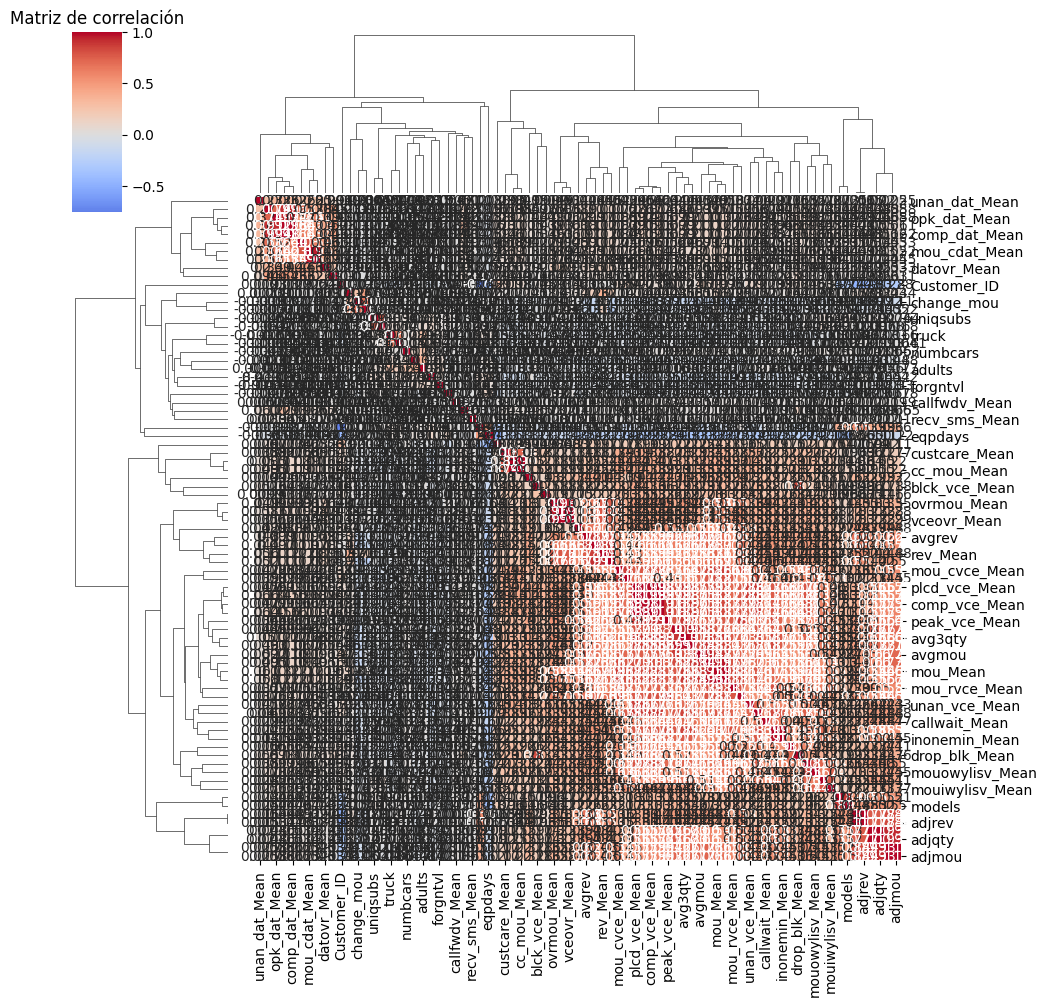

In [25]:
data_num = data.select_dtypes(include = [np.number])
correlation = data_num.corr()
plt.figure(figsize=(100,80))
sns.clustermap(correlation, annot=True, cmap='coolwarm', center = 0)
plt.title('Matriz de correlación')
plt.show()

In [26]:
missings = data.isnull().sum()
missings_pct = (missings/len(data)) * 100

missings_more_33 = missings_pct[missings_pct > 33].sort_values(ascending=False)
missings_more_33

numbcars    49.366
dwllsize    38.308
HHstatin    37.923
ownrent     33.706
dtype: float64

In [27]:
missings_between_5_and_33 = missings_pct[(missings_pct < 33) & (missings_pct > 5)].sort_values(ascending=False)
missings_between_5_and_33

dwlltype            31.909
lor                 30.190
income              25.436
adults              23.019
infobase            22.079
hnd_webcap          10.189
prizm_social_one     7.388
dtype: float64

In [40]:
columns_missings_less_33 = missings_pct[(missings_pct < 33) & (missings_pct > 0)].index.tolist()

df_missings_less_33 = data[columns_missings_less_33 + ['churn']]

df_num_missings_less_33 = df_missings_less_33.select_dtypes(include=[np.number])

corr_with_churn = df_num_missings_less_33.corrwith(df_num_missings_less_33['churn']).sort_values(ascending=False)

print(corr_with_churn.index)

Index(['churn', 'eqpdays', 'vceovr_Mean', 'ovrrev_Mean', 'ovrmou_Mean',
       'roam_Mean', 'change_rev', 'income', 'rv', 'datovr_Mean', 'truck',
       'forgntvl', 'adults', 'rev_Mean', 'da_Mean', 'avg6rev', 'change_mou',
       'avg6qty', 'phones', 'avg6mou', 'lor', 'models', 'mou_Mean',
       'totmrc_Mean', 'hnd_price'],
      dtype='object')


In [33]:
data['churn']

0        1
1        0
2        1
3        0
4        0
        ..
99995    1
99996    0
99997    0
99998    0
99999    1
Name: churn, Length: 100000, dtype: int64

In [112]:
def correct_missings(df, miss_pct_th = 33, threshold_num = 0.1, threshold_chi=0.05):
    
    missings_pct = (df.isnull().sum()/len(df)) * 100
    
    # Eliminamos directamente las columnas con un % de missing superior al 33%
    df = df.drop(columns = missings_pct[missings_pct > miss_pct_th].index)
    
    # Las columnas con missings entre 0 y 33 las dividiremos en 2 grupos, numéricas y categóricas:
    
    columns_missings = missings_pct[(missings_pct < miss_pct_th) & (missings_pct > 0)].index.tolist()
    df_missings = df[columns_missings + ['churn']]
    
    df_num_missings = df_missings.select_dtypes(include=[np.number])
    df_cat_missings = df_missings.select_dtypes(include=[object])
    
    # Numéricas
    print("Las columnas numéricas con nulos son las siguientes:\n", df_num_missings.index )
    
    corr_with_churn = df_num_missings.corrwith(df_num_missings['churn'])
    
    cols_to_keep = corr_with_churn[abs(corr_with_churn) >= threshold_num].index.tolist()
    
    print("Se van a imputar con la mediana las siguientes columnas:\n", cols_to_keep)

    
    if 'churn' not in cols_to_keep:
        cols_to_keep.append('churn')
        
    #print(cols_to_keep)

    for col in cols_to_keep:
        if col != 'churn':
            median = df_num_missings[col].median()
            df[col] = df[col].fillna(median)
    
    cols_to_drop = corr_with_churn[abs(corr_with_churn) < threshold_num].index.tolist()
    
    print("Se van a dropear las siguientes por baja correlación con la columna churn:\n", cols_to_drop)
    
    
    
    df = df.drop(columns = cols_to_drop)
    
    # Categóricas
    
    print("Las columnas numéricas con nulos son las siguientes:\n", df_cat_missings.index )

    
    if 'churn' not in df_cat_missings.columns:
        df_cat_missings['churn'] = df['churn']
        
    def chi2_test(cols, target):
        cont_table = pd.crosstab(cols, target)
        res = chi2_contingency(cont_table)
        return res.pvalue
    
    chi2_res = df_cat_missings.apply(lambda x: chi2_test(x, df['churn'])).sort_values()
    
    #print(chi2_res)
    
    cols_to_keep = chi2_res[chi2_res <= threshold_chi].index.tolist()
    
    print("Se van a imputar con la moda las siguientes columnas:\n", cols_to_keep)
    
    if 'churn' not in cols_to_keep:
        cols_to_keep.append('churn')
    
    for col in cols_to_keep:
        if col != 'churn':
            mode = df_cat_missings[col].mode()[0]
            df[col] = df[col].fillna(mode)
            
    cols_to_drop = chi2_res[chi2_res > threshold_chi].index.tolist()
    
    print("Se van a dropear las siguientes por baja correlación con la columna churn:\n", cols_to_drop)
    
    df = df.drop(columns = cols_to_drop)
    
    return df
    

Eliminamos directamente las columnas que tienen unos valores de missing mayores al 33%

In [113]:
data_test = correct_missings(data)
miss_data_test = data_test.isnull().sum()[data_test.isnull().sum() > 0]
data[miss_data_test.index].dtypes

Las columnas numéricas con nulos son las siguientes:
 RangeIndex(start=0, stop=100000, step=1)
Se van a imputar con la mediana las siguientes columnas:
 ['hnd_price', 'eqpdays', 'churn']
Se van a dropear las siguientes por baja correlación con la columna churn:
 ['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou', 'change_rev', 'avg6mou', 'avg6qty', 'avg6rev', 'phones', 'models', 'truck', 'rv', 'lor', 'adults', 'income', 'forgntvl']
Las columnas numéricas con nulos son las siguientes:
 RangeIndex(start=0, stop=100000, step=1)
Se van a imputar con la moda las siguientes columnas:
 ['churn', 'hnd_webcap', 'ethnic', 'dualband', 'area', 'refurb_new', 'marital', 'prizm_social_one', 'creditcd', 'infobase', 'dwlltype', 'kid0_2']
Se van a dropear las siguientes por baja correlación con la columna churn:
 ['kid3_5', 'kid16_17', 'kid11_15', 'kid6_10']


Series([], dtype: object)